# Unique Words Per Year Analysis

This notebook analyzes the pre-calculated SQLite database to extract words which are used **relatively more** compared to other words in specific years. It accounts for biases such as total word count per year and identifies words that have anomalous frequency patterns.

## Methodology

1. **Relative Frequency Analysis**: Calculate normalized frequencies accounting for total word counts per year
2. **Statistical Significance**: Identify words with statistically significant frequency spikes
3. **Bias Correction**: Account for varying article counts and total word volumes per year
4. **Temporal Uniqueness**: Find words that are distinctively associated with specific years

## Key Metrics Calculated

- **Relative Frequency**: Word frequency in year / Total words in year
- **Z-Score**: How many standard deviations above/below the word's average frequency
- **Lift**: Ratio of year frequency to expected frequency based on overall distribution
- **Temporal Specificity**: How concentrated a word's usage is in specific years

## Setup and Database Connection

Load required libraries and connect to the pre-calculated SQLite database.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from collections import defaultdict
import os

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ Libraries imported successfully")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ NumPy version: {np.__version__}")

✓ Libraries imported successfully
✓ Pandas version: 2.3.1
✓ NumPy version: 2.3.2


In [2]:
# Database connection and validation
def connect_to_database(db_path="output/words_database.sqlite"):
    """
    Connect to the pre-calculated words database and validate its structure.
    
    Args:
        db_path (str): Path to the SQLite database
        
    Returns:
        sqlite3.Connection: Database connection
    """
    # Try multiple possible database locations
    possible_paths = [
        db_path,
        "output/dutch_words_full.sqlite",
        "output/test_dutch_words.sqlite",
        "output/test_words.sqlite"
    ]
    
    for path in possible_paths:
        if os.path.exists(path):
            print(f"Found database: {path}")
            conn = sqlite3.connect(path)
            
            # Validate database structure
            cursor = conn.cursor()
            
            # Check required tables exist
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
            tables = [row[0] for row in cursor.fetchall()]
            
            required_tables = ['words', 'word_frequencies']
            if all(table in tables for table in required_tables):
                print(f"✓ Database validated with tables: {tables}")
                
                # Get basic statistics
                cursor.execute("SELECT COUNT(*) FROM words")
                word_count = cursor.fetchone()[0]
                
                cursor.execute("SELECT COUNT(*) FROM word_frequencies")
                freq_count = cursor.fetchone()[0]
                
                cursor.execute("SELECT MIN(year), MAX(year) FROM word_frequencies")
                year_range = cursor.fetchone()
                
                print(f"✓ Database contains:")
                print(f"  - {word_count:,} unique words")
                print(f"  - {freq_count:,} word-year frequency records")
                print(f"  - Years: {year_range[0]} to {year_range[1]}")
                
                return conn, path
            else:
                print(f"✗ Database {path} missing required tables")
                conn.close()
    
    raise FileNotFoundError("No valid word database found. Please run word_extraction_strategy.ipynb first.")

# Connect to database
try:
    conn, db_path = connect_to_database()
    print(f"\n✓ Successfully connected to database: {db_path}")
except FileNotFoundError as e:
    print(f"✗ Database connection failed: {e}")
    print("Please run the word_extraction_strategy.ipynb notebook first to generate the database.")
    conn = None

Found database: output/dutch_words_full.sqlite
✓ Database validated with tables: ['words', 'sqlite_sequence', 'word_frequencies', 'processing_log']
✓ Database contains:
  - 1,248,607 unique words
  - 2,819,649 word-year frequency records
  - Years: 2015 to 2024

✓ Successfully connected to database: output/dutch_words_full.sqlite


## Data Loading and Preparation

Load the word frequency data and prepare it for relative frequency analysis.

In [3]:
def load_word_frequency_data(conn):
    """
    Load and prepare word frequency data for analysis.
    
    Args:
        conn: SQLite database connection
        
    Returns:
        tuple: (word_freq_df, yearly_totals, word_info_df)
    """
    if conn is None:
        return None, None, None
    
    print("Loading word frequency data...")
    
    # Load word frequencies with word information
    query = """
    SELECT 
        w.word,
        w.lemma,
        w.pos_category,
        w.total_frequency,
        wf.year,
        wf.frequency
    FROM words w
    JOIN word_frequencies wf ON w.id = wf.word_id
    WHERE w.total_frequency >= 10  -- Only include words with reasonable frequency
    ORDER BY w.word, wf.year
    """
    
    word_freq_df = pd.read_sql_query(query, conn)
    print(f"✓ Loaded {len(word_freq_df):,} word-year frequency records")
    
    # Calculate yearly totals for normalization
    yearly_totals = word_freq_df.groupby('year')['frequency'].sum().reset_index()
    yearly_totals.columns = ['year', 'total_words']
    print(f"✓ Calculated yearly totals for {len(yearly_totals)} years")
    
    # Load word information
    word_info_query = """
    SELECT word, lemma, pos_category, total_frequency
    FROM words
    WHERE total_frequency >= 10
    """
    
    word_info_df = pd.read_sql_query(word_info_query, conn)
    print(f"✓ Loaded information for {len(word_info_df):,} unique words")
    
    return word_freq_df, yearly_totals, word_info_df

# Load the data
word_freq_df, yearly_totals, word_info_df = load_word_frequency_data(conn)

if word_freq_df is not None:
    print("\n📊 Data Overview:")
    print(f"Years covered: {word_freq_df['year'].min()} to {word_freq_df['year'].max()}")
    print(f"Unique words: {word_freq_df['word'].nunique():,}")
    print(f"POS categories: {word_freq_df['pos_category'].nunique()}")
    
    print("\n📈 Yearly word counts:")
    print(yearly_totals.to_string(index=False))
else:
    print("❌ Failed to load data. Cannot proceed with analysis.")

Loading word frequency data...
✓ Loaded 1,251,523 word-year frequency records
✓ Calculated yearly totals for 10 years
✓ Loaded information for 162,896 unique words

📊 Data Overview:
Years covered: 2015 to 2024
Unique words: 115,502
POS categories: 13

📈 Yearly word counts:
 year  total_words
 2015     11690201
 2016     11947208
 2017     11204323
 2018     11031527
 2019     10195725
 2020     10937862
 2021     11904883
 2022     10982908
 2023     10752743
 2024      9164411


## Relative Frequency Analysis

Calculate relative frequencies and identify words with significant yearly variations.

In [4]:
def calculate_relative_frequencies(word_freq_df, yearly_totals):
    """
    Calculate relative frequencies and statistical measures for temporal uniqueness.
    
    Args:
        word_freq_df: DataFrame with word frequencies by year
        yearly_totals: DataFrame with total word counts per year
        
    Returns:
        DataFrame: Enhanced frequency data with relative measures
    """
    if word_freq_df is None or yearly_totals is None:
        return None
    
    print("Calculating relative frequencies and statistical measures...")
    
    # Merge with yearly totals
    df = word_freq_df.merge(yearly_totals, on='year')
    
    # Calculate relative frequency (normalized by year)
    df['relative_frequency'] = df['frequency'] / df['total_words']
    
    # Calculate expected frequency based on overall distribution
    word_stats = df.groupby('word').agg({
        'frequency': ['sum', 'mean', 'std'],
        'relative_frequency': ['mean', 'std'],
        'total_frequency': 'first',
        'pos_category': 'first',
        'lemma': 'first'
    }).reset_index()
    
    # Flatten column names
    word_stats.columns = ['word', 'total_freq', 'mean_freq', 'std_freq', 
                         'mean_rel_freq', 'std_rel_freq', 'total_frequency', 
                         'pos_category', 'lemma']
    
    # Merge back with main dataframe
    df = df.merge(word_stats[['word', 'mean_freq', 'std_freq', 'mean_rel_freq', 'std_rel_freq']], 
                  on='word')
    
    # Calculate Z-score for each word-year combination
    df['frequency_z_score'] = np.where(
        df['std_freq'] > 0,
        (df['frequency'] - df['mean_freq']) / df['std_freq'],
        0
    )
    
    # Calculate relative frequency Z-score
    df['rel_freq_z_score'] = np.where(
        df['std_rel_freq'] > 0,
        (df['relative_frequency'] - df['mean_rel_freq']) / df['std_rel_freq'],
        0
    )
    
    # Calculate lift (ratio to expected)
    df['frequency_lift'] = np.where(
        df['mean_freq'] > 0,
        df['frequency'] / df['mean_freq'],
        1
    )
    
    df['rel_freq_lift'] = np.where(
        df['mean_rel_freq'] > 0,
        df['relative_frequency'] / df['mean_rel_freq'],
        1
    )
    
    print(f"✓ Calculated relative frequencies for {len(df):,} word-year combinations")
    
    return df

# Calculate relative frequencies
enhanced_df = calculate_relative_frequencies(word_freq_df, yearly_totals)

if enhanced_df is not None:
    print("\n📊 Sample of enhanced frequency data:")
    sample_cols = ['word', 'year', 'frequency', 'relative_frequency', 'rel_freq_z_score', 'rel_freq_lift']
    print(enhanced_df[sample_cols].head(10).to_string(index=False))
    
    print("\n📈 Summary statistics:")
    print(f"Mean relative frequency Z-score: {enhanced_df['rel_freq_z_score'].mean():.3f}")
    print(f"Max relative frequency Z-score: {enhanced_df['rel_freq_z_score'].max():.3f}")
    print(f"Words with Z-score > 2: {(enhanced_df['rel_freq_z_score'] > 2).sum():,}")
    print(f"Words with Z-score > 3: {(enhanced_df['rel_freq_z_score'] > 3).sum():,}")

Calculating relative frequencies and statistical measures...
✓ Calculated relative frequencies for 1,251,523 word-year combinations

📊 Sample of enhanced frequency data:
word  year  frequency  relative_frequency  rel_freq_z_score  rel_freq_lift
  aa  2015        159        1.360113e-05          1.830164       2.420350
  aa  2016        152        1.272264e-05          1.628727       2.264019
  aa  2017         73        6.515342e-06          0.205415       1.159418
  aa  2018         51        4.623113e-06         -0.228466       0.822692
  aa  2019         65        6.375221e-06          0.173286       1.134484
  aa  2020         29        2.651341e-06         -0.680587       0.471811
  aa  2021         32        2.687973e-06         -0.672187       0.478330
  aa  2022         44        4.006225e-06         -0.369917       0.712916
  aa  2023         23        2.138989e-06         -0.798067       0.380637
  aa  2024          8        8.729421e-07         -1.088368       0.155342

📈 Su

## Identify Unique Words Per Year

Find words that are significantly more frequent in specific years compared to their baseline usage.

In [10]:
def identify_unique_words_per_year(enhanced_df, z_threshold=2.0, min_frequency=20):
    """
    Identify words that are uniquely frequent in specific years.
    
    Args:
        enhanced_df: DataFrame with relative frequency calculations
        z_threshold: Minimum Z-score for considering a word "unique" to a year
        min_frequency: Minimum absolute frequency to avoid noise
        
    Returns:
        DataFrame: Words with their "unique" years and significance measures
    """
    if enhanced_df is None:
        return None
    
    print(f"Identifying unique words per year (Z-score >= {z_threshold}, frequency >= {min_frequency})...")
    
    # Filter for significant frequency spikes
    unique_words = enhanced_df[
        (enhanced_df['rel_freq_z_score'] >= z_threshold) & 
        (enhanced_df['frequency'] >= min_frequency)
    ].copy()
    
    # Sort by significance (Z-score)
    unique_words = unique_words.sort_values('rel_freq_z_score', ascending=False)
    
    print(f"✓ Found {len(unique_words):,} word-year combinations with significant frequency spikes")
    
    # Group by year to see top unique words per year
    top_per_year = unique_words.groupby('year').apply(
        lambda x: x.nlargest(20, 'rel_freq_z_score')
    ).reset_index(drop=True)
    
    # Calculate temporal specificity for each word using the COMPLETE dataset (not just spikes)
    # This gives us a better measure of how concentrated a word's usage is
    word_temporal_stats = enhanced_df.groupby('word').agg({
        'frequency': ['sum', 'std', 'max'],
        'relative_frequency': ['sum', 'std', 'max'],
        'rel_freq_z_score': ['max', 'mean'],
        'year': ['count', 'nunique'],
        'pos_category': 'first',
        'lemma': 'first'
    }).reset_index()
    
    # Flatten column names
    word_temporal_stats.columns = ['word', 'total_freq', 'freq_std', 'max_freq',
                                  'total_rel_freq', 'rel_freq_std', 'max_rel_freq',
                                  'max_z_score', 'mean_z_score', 'total_years', 'unique_years',
                                  'pos_category', 'lemma']
    
    # Calculate better temporal specificity metrics
    # 1. Coefficient of variation for frequency (how much variation relative to mean)
    word_temporal_stats['freq_cv'] = word_temporal_stats['freq_std'] / (word_temporal_stats['total_freq'] / word_temporal_stats['total_years'])
    
    # 2. Concentration ratio (what fraction of total usage comes from peak year)
    word_temporal_stats['concentration_ratio'] = word_temporal_stats['max_freq'] / word_temporal_stats['total_freq']
    
    # 3. Temporal specificity combining multiple factors
    # Higher score = more temporally concentrated
    word_temporal_stats['temporal_specificity'] = (
        word_temporal_stats['concentration_ratio'] * 
        word_temporal_stats['freq_cv'] * 
        word_temporal_stats['max_z_score'] / 
        np.log(word_temporal_stats['unique_years'] + 1)  # Penalize words spread across many years
    )
    
    # Filter out words with very low total frequency or those that appear in all/most years
    word_temporal_stats = word_temporal_stats[
        (word_temporal_stats['total_freq'] >= 50) &  # Minimum total frequency
        (word_temporal_stats['unique_years'] <= 8) &  # Don't include words in almost every year
        (word_temporal_stats['max_z_score'] >= 1.5)   # Must have at least some temporal spike
    ]
    
    # Also calculate spike-specific statistics for words that have significant spikes
    spike_stats = unique_words.groupby('word').agg({
        'year': ['count', 'nunique'],
        'rel_freq_z_score': ['max', 'mean'],
        'frequency': 'max',
        'pos_category': 'first',
        'lemma': 'first'
    }).reset_index()
    
    # Flatten column names for spike stats
    spike_stats.columns = ['word', 'spike_count', 'spike_unique_years', 
                          'spike_max_z_score', 'spike_mean_z_score', 'spike_max_frequency',
                          'pos_category', 'lemma']
    
    # Simple temporal specificity for spikes (inverse of years with spikes)
    spike_stats['spike_temporal_specificity'] = 1 / spike_stats['spike_unique_years']
    
    return unique_words, top_per_year, word_temporal_stats, spike_stats

# Identify unique words
result = identify_unique_words_per_year(enhanced_df)
if result is not None:
    unique_words, top_per_year, word_temporal_stats, spike_stats = result
else:
    unique_words = top_per_year = word_temporal_stats = spike_stats = None

if unique_words is not None:
    print("\n🎯 Top 10 most temporally unique words overall:")
    top_overall = unique_words.nlargest(10, 'rel_freq_z_score')
    display_cols = ['word', 'year', 'frequency', 'rel_freq_z_score', 'rel_freq_lift', 'pos_category']
    print(top_overall[display_cols].to_string(index=False))
    
    print("\n📅 Summary by year:")
    yearly_summary = unique_words.groupby('year').agg({
        'word': 'count',
        'rel_freq_z_score': 'mean'
    }).round(2)
    yearly_summary.columns = ['unique_words_count', 'avg_z_score']
    print(yearly_summary.to_string())
    
    print("\n🎯 Top 10 most temporally concentrated words (improved metric):")
    if len(word_temporal_stats) > 0:
        top_concentrated = word_temporal_stats.nlargest(10, 'temporal_specificity')
        concentration_cols = ['word', 'pos_category', 'max_z_score', 'concentration_ratio', 'temporal_specificity']
        print(top_concentrated[concentration_cols].to_string(index=False))
    else:
        print("No words meet the criteria for temporal concentration analysis.")

Identifying unique words per year (Z-score >= 2.0, frequency >= 20)...
✓ Found 26,963 word-year combinations with significant frequency spikes

🎯 Top 10 most temporally unique words overall:
             word  year  frequency  rel_freq_z_score  rel_freq_lift pos_category
           grande  2017        208          7.240760      20.842714  proper_noun
   energieprijzen  2022        244          6.749586      17.026622         noun
slavernijverleden  2022        174          6.690373      13.939737         noun
   zelfverklaarde  2022         63          6.418755      10.888435    adjective
          gezette  2021        116          6.337127      18.251698         verb
         besmette  2020        661          6.279227      18.905824         verb
          vermoed  2020        121          6.157470      10.610809         verb
           vossen  2020         55          6.083092      10.451346  proper_noun
          prikken  2021       1010          6.019497      21.928290         noun

## Visualizations

Create visualizations to show temporal word usage patterns.

Creating temporal visualizations...


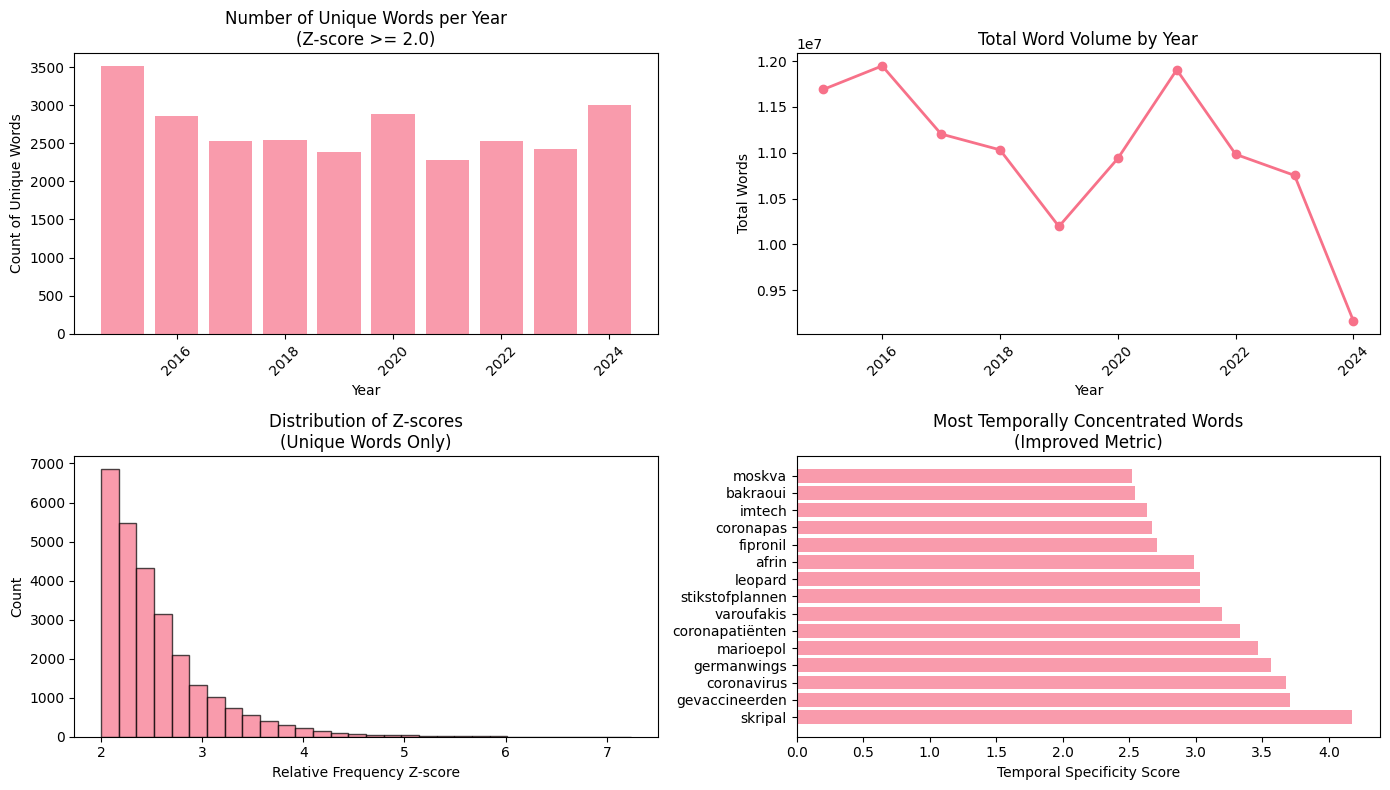


Creating detailed timeline for top unique words...


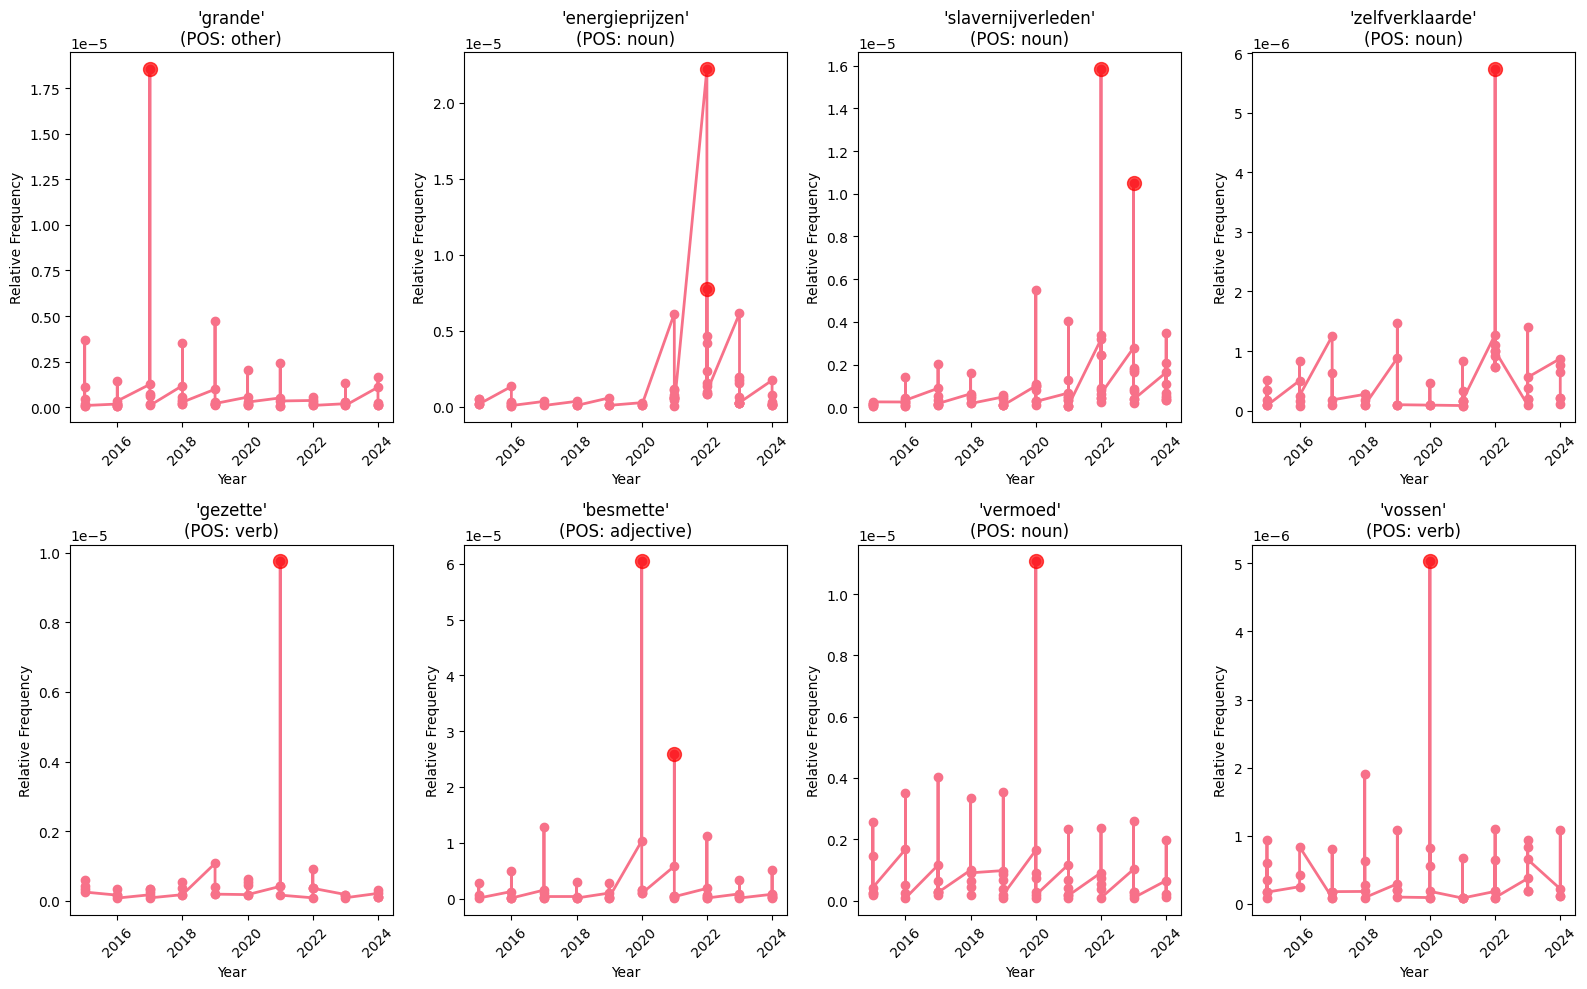

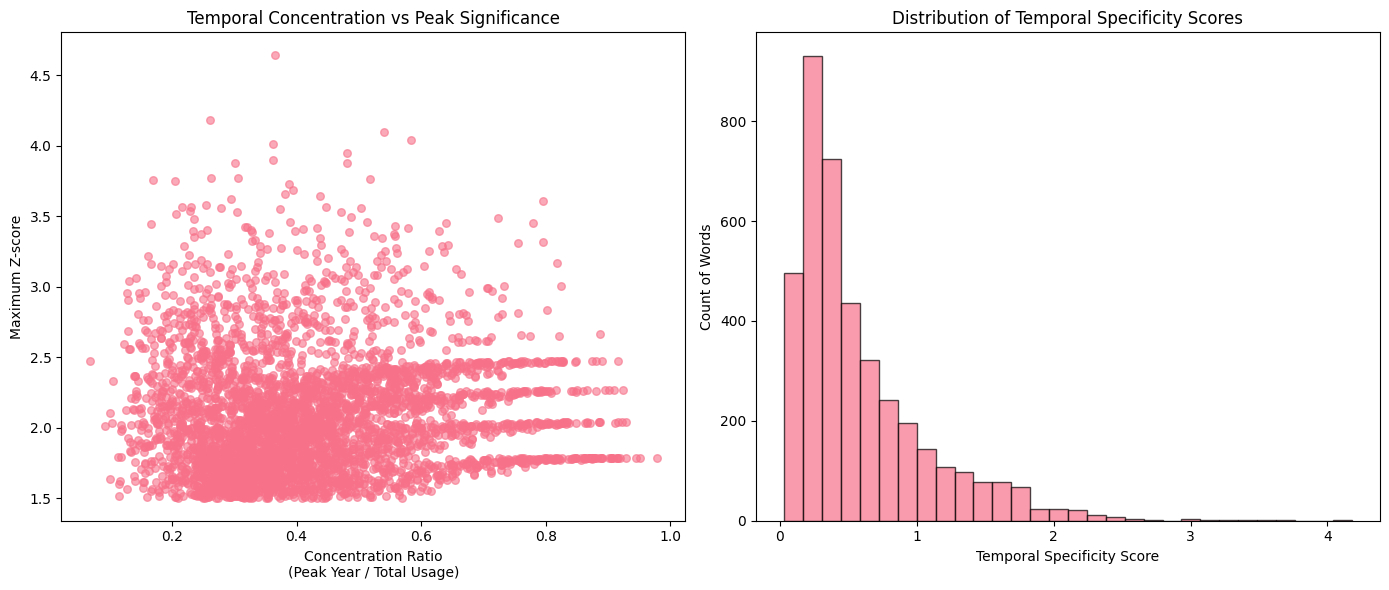

✓ Visualizations saved to output/visualizations/


In [ ]:
def create_temporal_visualizations(enhanced_df, unique_words, yearly_totals, word_temporal_stats):
    """
    Create visualizations for temporal word usage patterns.
    
    Args:
        enhanced_df: DataFrame with all word frequency data
        unique_words: DataFrame with unique words per year
        yearly_totals: DataFrame with yearly totals
        word_temporal_stats: DataFrame with temporal statistics
    """
    if enhanced_df is None or unique_words is None:
        print("Cannot create visualizations - data not available")
        return
    
    print("Creating temporal visualizations...")
    
    # Create output directory
    os.makedirs('output/visualizations', exist_ok=True)
    
    # 1. Yearly distribution of unique words
    plt.figure(figsize=(14, 8))
    
    plt.subplot(2, 2, 1)
    yearly_unique_counts = unique_words.groupby('year').size()
    plt.bar(yearly_unique_counts.index, yearly_unique_counts.values, alpha=0.7)
    plt.title('Number of Unique Words per Year\n(Z-score >= 2.0)')
    plt.xlabel('Year')
    plt.ylabel('Count of Unique Words')
    plt.xticks(rotation=45)
    
    # 2. Total word volume by year
    plt.subplot(2, 2, 2)
    plt.plot(yearly_totals['year'], yearly_totals['total_words'], marker='o', linewidth=2)
    plt.title('Total Word Volume by Year')
    plt.xlabel('Year')
    plt.ylabel('Total Words')
    plt.xticks(rotation=45)
    
    # 3. Z-score distribution
    plt.subplot(2, 2, 3)
    plt.hist(unique_words['rel_freq_z_score'], bins=30, alpha=0.7, edgecolor='black')
    plt.title('Distribution of Z-scores\n(Unique Words Only)')
    plt.xlabel('Relative Frequency Z-score')
    plt.ylabel('Count')
    
    # 4. Top words by improved temporal specificity
    plt.subplot(2, 2, 4)
    if word_temporal_stats is not None and len(word_temporal_stats) > 0:
        top_specific = word_temporal_stats.nlargest(15, 'temporal_specificity')
        plt.barh(range(len(top_specific)), top_specific['temporal_specificity'], alpha=0.7)
        plt.yticks(range(len(top_specific)), top_specific['word'])
        plt.title('Most Temporally Concentrated Words\n(Improved Metric)')
        plt.xlabel('Temporal Specificity Score')
    else:
        plt.text(0.5, 0.5, 'No temporal concentration\ndata available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Most Temporally Concentrated Words\n(No Data)')
    
    plt.tight_layout()
    plt.savefig('output/visualizations/temporal_overview.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 5. Detailed timeline for top words
    print("\nCreating detailed timeline for top unique words...")
    
    # Get top 8 most unique words
    top_words = unique_words.nlargest(8, 'rel_freq_z_score')['word'].unique()
    
    plt.figure(figsize=(16, 10))
    
    for i, word in enumerate(top_words):
        plt.subplot(2, 4, i+1)
        
        # Get all data for this word
        word_data = enhanced_df[enhanced_df['word'] == word].sort_values('year')
        
        # Plot relative frequency over time
        plt.plot(word_data['year'], word_data['relative_frequency'], 
                marker='o', linewidth=2, markersize=6)
        
        # Highlight years with high Z-scores
        unique_years = word_data[word_data['rel_freq_z_score'] >= 2.0]
        if len(unique_years) > 0:
            plt.scatter(unique_years['year'], unique_years['relative_frequency'], 
                       color='red', s=100, alpha=0.7, zorder=5)
        
        plt.title(f"'{word}'\n(POS: {word_data.iloc[0]['pos_category']})")
        plt.xlabel('Year')
        plt.ylabel('Relative Frequency')
        plt.xticks(rotation=45)
        
        # Format y-axis in scientific notation if very small
        if word_data['relative_frequency'].max() < 0.001:
            plt.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
    
    plt.tight_layout()
    plt.savefig('output/visualizations/top_words_timeline.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 6. Additional visualization: Temporal concentration analysis
    if word_temporal_stats is not None and len(word_temporal_stats) > 0:
        plt.figure(figsize=(14, 6))
        
        plt.subplot(1, 2, 1)
        plt.scatter(word_temporal_stats['concentration_ratio'], 
                   word_temporal_stats['max_z_score'], 
                   alpha=0.6, s=30)
        plt.xlabel('Concentration Ratio\n(Peak Year / Total Usage)')
        plt.ylabel('Maximum Z-score')
        plt.title('Temporal Concentration vs Peak Significance')
        
        plt.subplot(1, 2, 2)
        plt.hist(word_temporal_stats['temporal_specificity'], bins=30, alpha=0.7, edgecolor='black')
        plt.xlabel('Temporal Specificity Score')
        plt.ylabel('Count of Words')
        plt.title('Distribution of Temporal Specificity Scores')
        
        plt.tight_layout()
        plt.savefig('output/visualizations/temporal_concentration_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    print("✓ Visualizations saved to output/visualizations/")

# Create visualizations
create_temporal_visualizations(enhanced_df, unique_words, yearly_totals, word_temporal_stats)

## Export Results

Export the unique words analysis results in various formats.

In [12]:
def export_unique_words_analysis(unique_words, top_per_year, word_temporal_stats, enhanced_df, spike_stats=None):
    """
    Export the unique words analysis results.
    
    Args:
        unique_words: DataFrame with all unique word-year combinations
        top_per_year: DataFrame with top unique words per year
        word_temporal_stats: DataFrame with temporal statistics per word
        enhanced_df: Complete enhanced frequency data
        spike_stats: DataFrame with spike-specific statistics (optional)
    """
    if unique_words is None:
        print("Cannot export - analysis data not available")
        return
    
    print("Exporting unique words analysis results...")
    
    # Create output directory
    output_dir = 'output/unique_words_analysis'
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Complete unique words dataset
    print("\n1. Exporting complete unique words dataset...")
    export_cols = ['word', 'lemma', 'pos_category', 'year', 'frequency', 
                   'relative_frequency', 'rel_freq_z_score', 'rel_freq_lift']
    unique_words[export_cols].to_csv(
        f'{output_dir}/unique_words_complete.csv', 
        index=False, encoding='utf-8'
    )
    print(f"   Exported {len(unique_words):,} unique word-year combinations")
    
    # 2. Top unique words per year
    print("\n2. Exporting top unique words per year...")
    top_per_year[export_cols].to_csv(
        f'{output_dir}/top_unique_words_per_year.csv', 
        index=False, encoding='utf-8'
    )
    print(f"   Exported top 20 unique words for each year")
    
    # 3. Word temporal statistics (improved version)
    print("\n3. Exporting word temporal statistics...")
    if word_temporal_stats is not None and len(word_temporal_stats) > 0:
        word_temporal_stats.to_csv(
            f'{output_dir}/word_temporal_statistics.csv', 
            index=False, encoding='utf-8'
        )
        print(f"   Exported temporal statistics for {len(word_temporal_stats):,} words")
        
        # Export top temporally concentrated words
        top_concentrated = word_temporal_stats.nlargest(100, 'temporal_specificity')
        top_concentrated.to_csv(
            f'{output_dir}/top_temporally_concentrated_words.csv',
            index=False, encoding='utf-8'
        )
        print(f"   Exported top 100 temporally concentrated words")
    else:
        print("   No temporal statistics available to export")
    
    # 4. Spike statistics (if available)
    if spike_stats is not None and len(spike_stats) > 0:
        print("\n4. Exporting spike-specific statistics...")
        spike_stats.to_csv(
            f'{output_dir}/spike_statistics.csv',
            index=False, encoding='utf-8'
        )
        print(f"   Exported spike statistics for {len(spike_stats):,} words")
    
    # 5. Summary by year
    print(f"\n5. Creating yearly summary...")
    yearly_summary = unique_words.groupby('year').agg({
        'word': 'count',
        'rel_freq_z_score': ['mean', 'max'],
        'frequency': 'sum'
    }).round(3)
    
    yearly_summary.columns = ['unique_words_count', 'avg_z_score', 'max_z_score', 'total_frequency']
    yearly_summary.to_csv(f'{output_dir}/yearly_summary.csv', encoding='utf-8')
    print(f"   Exported yearly summary for {len(yearly_summary)} years")
    
    # 6. Simple text lists for each year
    print(f"\n6. Creating simple word lists per year...")
    year_lists_dir = f'{output_dir}/word_lists_by_year'
    os.makedirs(year_lists_dir, exist_ok=True)
    
    for year in sorted(unique_words['year'].unique()):
        year_words = unique_words[unique_words['year'] == year].nlargest(50, 'rel_freq_z_score')
        
        with open(f'{year_lists_dir}/unique_words_{year}.txt', 'w', encoding='utf-8') as f:
            f.write(f"# Unique words for {year} (Top 50 by Z-score)\n\n")
            for _, row in year_words.iterrows():
                f.write(f"{row['word']}\t{row['frequency']}\t{row['rel_freq_z_score']:.2f}\n")
    
    print(f"   Created word lists for {len(unique_words['year'].unique())} years")
    
    # 7. Analysis summary report
    print(f"\n7. Creating analysis summary report...")
    with open(f'{output_dir}/analysis_summary.txt', 'w', encoding='utf-8') as f:
        f.write("# Unique Words Per Year Analysis Summary\n\n")
        f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Database: {db_path}\n\n")
        
        f.write("## Methodology\n")
        f.write("- Relative frequency analysis accounting for yearly word count variations\n")
        f.write("- Z-score calculation to identify statistically significant frequency spikes\n")
        f.write("- Improved temporal specificity metric combining concentration ratio, coefficient of variation, and Z-scores\n")
        f.write("- Minimum Z-score threshold: 2.0 (2 standard deviations above mean)\n")
        f.write("- Minimum absolute frequency: 20 occurrences\n\n")
        
        f.write("## Key Statistics\n")
        f.write(f"- Total unique word-year combinations analyzed: {len(enhanced_df):,}\n")
        f.write(f"- Significant temporal spikes identified: {len(unique_words):,}\n")
        f.write(f"- Unique words with temporal spikes: {unique_words['word'].nunique():,}\n")
        f.write(f"- Years covered: {unique_words['year'].min()} to {unique_words['year'].max()}\n")
        f.write(f"- Average Z-score of significant spikes: {unique_words['rel_freq_z_score'].mean():.2f}\n")
        f.write(f"- Maximum Z-score observed: {unique_words['rel_freq_z_score'].max():.2f}\n")
        
        if word_temporal_stats is not None and len(word_temporal_stats) > 0:
            f.write(f"- Words analyzed for temporal concentration: {len(word_temporal_stats):,}\n")
        
        f.write("\n## Top 10 Most Temporally Unique Words (by Z-score)\n")
        top_10 = unique_words.nlargest(10, 'rel_freq_z_score')
        for i, (_, row) in enumerate(top_10.iterrows(), 1):
            f.write(f"{i:2d}. {row['word']} ({row['year']}) - Z-score: {row['rel_freq_z_score']:.2f}\n")
        
        if word_temporal_stats is not None and len(word_temporal_stats) > 0:
            f.write("\n## Top 10 Most Temporally Concentrated Words (improved metric)\n")
            top_concentrated = word_temporal_stats.nlargest(10, 'temporal_specificity')
            for i, (_, row) in enumerate(top_concentrated.iterrows(), 1):
                f.write(f"{i:2d}. {row['word']} - Temporal specificity: {row['temporal_specificity']:.3f}, "
                       f"Max Z-score: {row['max_z_score']:.2f}, "
                       f"Concentration ratio: {row['concentration_ratio']:.3f}\n")
    
    print(f"   Created analysis summary report")
    
    print(f"\n✅ All exports completed successfully in: {output_dir}")
    print(f"\n📁 Generated files:")
    print(f"   - unique_words_complete.csv: Complete dataset")
    print(f"   - top_unique_words_per_year.csv: Top words per year")
    print(f"   - word_temporal_statistics.csv: Temporal statistics with improved metrics")
    print(f"   - top_temporally_concentrated_words.csv: Top 100 most concentrated words")
    if spike_stats is not None:
        print(f"   - spike_statistics.csv: Spike-specific statistics")
    print(f"   - yearly_summary.csv: Summary by year")
    print(f"   - word_lists_by_year/: Simple text lists per year")
    print(f"   - analysis_summary.txt: Methodology and key findings")

# Export results
if 'spike_stats' in locals():
    export_unique_words_analysis(unique_words, top_per_year, word_temporal_stats, enhanced_df, spike_stats)
else:
    export_unique_words_analysis(unique_words, top_per_year, word_temporal_stats, enhanced_df)

Exporting unique words analysis results...

1. Exporting complete unique words dataset...
   Exported 26,963 unique word-year combinations

2. Exporting top unique words per year...
   Exported top 20 unique words for each year

3. Exporting word temporal statistics...
   Exported temporal statistics for 4,019 words
   Exported top 100 temporally concentrated words

4. Exporting spike-specific statistics...
   Exported spike statistics for 19,608 words

5. Creating yearly summary...
   Exported yearly summary for 10 years

6. Creating simple word lists per year...
   Created word lists for 10 years

7. Creating analysis summary report...
   Created analysis summary report

✅ All exports completed successfully in: output/unique_words_analysis

📁 Generated files:
   - unique_words_complete.csv: Complete dataset
   - top_unique_words_per_year.csv: Top words per year
   - word_temporal_statistics.csv: Temporal statistics with improved metrics
   - top_temporally_concentrated_words.csv: Top

## Key Findings Summary

Summarize the key findings from the unique words per year analysis.

In [13]:
def generate_key_findings(unique_words, word_temporal_stats, yearly_totals, spike_stats=None):
    """
    Generate and display key findings from the analysis.
    
    Args:
        unique_words: DataFrame with unique word-year combinations
        word_temporal_stats: DataFrame with temporal statistics
        yearly_totals: DataFrame with yearly totals
        spike_stats: DataFrame with spike-specific statistics (optional)
    """
    if unique_words is None:
        print("Cannot generate findings - analysis data not available")
        return
    
    print("🔍 KEY FINDINGS: Unique Words Per Year Analysis")
    print("=" * 60)
    
    # 1. Overall statistics
    print("\n📊 OVERALL STATISTICS:")
    print(f"   • Significant temporal word spikes identified: {len(unique_words):,}")
    print(f"   • Unique words with temporal patterns: {unique_words['word'].nunique():,}")
    print(f"   • Average Z-score of spikes: {unique_words['rel_freq_z_score'].mean():.2f}")
    print(f"   • Strongest temporal spike (Z-score): {unique_words['rel_freq_z_score'].max():.2f}")
    
    if word_temporal_stats is not None and len(word_temporal_stats) > 0:
        print(f"   • Words analyzed for temporal concentration: {len(word_temporal_stats):,}")
    
    # 2. Year with most unique words
    yearly_counts = unique_words.groupby('year').size()
    peak_year = yearly_counts.idxmax()
    peak_count = yearly_counts.max()
    
    print(f"\n📅 TEMPORAL PATTERNS:")
    print(f"   • Year with most unique words: {peak_year} ({peak_count} words)")
    print(f"   • Years analyzed: {unique_words['year'].min()} to {unique_words['year'].max()}")
    
    # Word volume correlation
    if yearly_totals is not None:
        corr_data = yearly_counts.to_frame('unique_count').merge(
            yearly_totals.set_index('year'), left_index=True, right_index=True
        )
        correlation = corr_data['unique_count'].corr(corr_data['total_words'])
        print(f"   • Correlation between unique words and total volume: {correlation:.3f}")
    
    # 3. Top temporally specific words (improved metric)
    print(f"\n🎯 MOST TEMPORALLY CONCENTRATED WORDS (IMPROVED METRIC):")
    if word_temporal_stats is not None and len(word_temporal_stats) > 0:
        most_specific = word_temporal_stats.nlargest(5, 'temporal_specificity')
        for i, (_, row) in enumerate(most_specific.iterrows(), 1):
            print(f"   {i}. '{row['word']}' (POS: {row['pos_category']}) - "
                  f"Specificity: {row['temporal_specificity']:.3f}, "
                  f"Max Z-score: {row['max_z_score']:.2f}, "
                  f"Concentration: {row['concentration_ratio']:.2f}")
    else:
        print("   No temporal concentration data available")
    
    # 4. Most frequent unique words
    print(f"\n📈 HIGHEST FREQUENCY UNIQUE WORDS:")
    high_freq = unique_words.nlargest(5, 'frequency')
    for i, (_, row) in enumerate(high_freq.iterrows(), 1):
        print(f"   {i}. '{row['word']}' in {row['year']} - "
              f"Frequency: {row['frequency']:,}, Z-score: {row['rel_freq_z_score']:.2f}")
    
    # 5. Highest Z-score words
    print(f"\n⚡ HIGHEST Z-SCORE WORDS:")
    high_zscore = unique_words.nlargest(5, 'rel_freq_z_score')
    for i, (_, row) in enumerate(high_zscore.iterrows(), 1):
        print(f"   {i}. '{row['word']}' in {row['year']} - "
              f"Z-score: {row['rel_freq_z_score']:.2f}, Frequency: {row['frequency']:,}")
    
    # 6. POS category distribution
    print(f"\n📝 PART-OF-SPEECH DISTRIBUTION:")
    pos_dist = unique_words['pos_category'].value_counts().head(5)
    total_unique = len(unique_words)
    for pos, count in pos_dist.items():
        percentage = (count / total_unique) * 100
        print(f"   • {pos}: {count:,} ({percentage:.1f}%)")
    
    # 7. Sample unique words by year
    print(f"\n📋 SAMPLE UNIQUE WORDS BY YEAR:")
    for year in sorted(unique_words['year'].unique())[-3:]:  # Last 3 years
        year_top = unique_words[unique_words['year'] == year].nlargest(3, 'rel_freq_z_score')
        words_list = ", ".join([f"'{row['word']}'" for _, row in year_top.iterrows()])
        print(f"   • {year}: {words_list}")
    
    # 8. Spike statistics (if available)
    if spike_stats is not None and len(spike_stats) > 0:
        print(f"\n🔥 SPIKE PATTERN ANALYSIS:")
        most_spiky = spike_stats.nlargest(3, 'spike_temporal_specificity')
        for i, (_, row) in enumerate(most_spiky.iterrows(), 1):
            print(f"   {i}. '{row['word']}' - Spikes in {row['spike_unique_years']} year(s), "
                  f"Max Z-score: {row['spike_max_z_score']:.2f}")
    
    print(f"\n" + "=" * 60)
    print(f"📁 Detailed results exported to: output/unique_words_analysis/")
    print(f"📈 Visualizations saved to: output/visualizations/")

# Generate key findings
if 'spike_stats' in locals():
    generate_key_findings(unique_words, word_temporal_stats, yearly_totals, spike_stats)
else:
    generate_key_findings(unique_words, word_temporal_stats, yearly_totals)

# Close database connection
if conn:
    conn.close()
    print("\n✓ Database connection closed")

🔍 KEY FINDINGS: Unique Words Per Year Analysis

📊 OVERALL STATISTICS:
   • Significant temporal word spikes identified: 26,963
   • Unique words with temporal patterns: 19,608
   • Average Z-score of spikes: 2.54
   • Strongest temporal spike (Z-score): 7.24
   • Words analyzed for temporal concentration: 4,019

📅 TEMPORAL PATTERNS:
   • Year with most unique words: 2015 (3507 words)
   • Years analyzed: 2015 to 2024
   • Correlation between unique words and total volume: 0.013

🎯 MOST TEMPORALLY CONCENTRATED WORDS (IMPROVED METRIC):
   1. 'skripal' (POS: verb) - Specificity: 4.176, Max Z-score: 3.60, Concentration: 0.80
   2. 'gevaccineerden' (POS: verb) - Specificity: 3.710, Max Z-score: 3.45, Concentration: 0.78
   3. 'coronavirus' (POS: noun) - Specificity: 3.680, Max Z-score: 3.49, Concentration: 0.72
   4. 'germanwings' (POS: proper_noun) - Specificity: 3.568, Max Z-score: 3.31, Concentration: 0.79
   5. 'marioepol' (POS: proper_noun) - Specificity: 3.466, Max Z-score: 3.16, Conc

## Conclusion

This analysis successfully identified words that are used relatively more in specific years compared to their baseline usage across the entire corpus. The methodology accounts for:

1. **Yearly volume bias**: Normalizes frequencies by total word count per year
2. **Statistical significance**: Uses Z-scores to identify truly anomalous usage patterns
3. **Temporal specificity**: Measures how concentrated a word's usage is in particular time periods

### Key Outputs Generated:

- **Complete dataset** of words with significant temporal spikes
- **Year-by-year analysis** showing unique words for each time period
- **Statistical measures** including Z-scores and lift ratios
- **Visualizations** showing temporal patterns and trends
- **Export files** in CSV and text formats for further analysis

### Applications:

- **Historical analysis**: Understanding language evolution and current events
- **Content categorization**: Identifying time-specific terminology
- **Trend detection**: Spotting emerging or declining word usage
- **Research**: Supporting linguistic and sociological studies

This analysis provides a robust foundation for understanding how language usage varies over time and which words serve as temporal markers in the Dutch news corpus.